# Arabic Sentiment Analysis Pipeline


## Import Libraries

In [10]:
import pandas as pd
import re
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mu7annad.0gmail.com/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mu7annad.0gmail.com/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/mu7annad.0gmail.com/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## 1. Text Preprocessing

### 1.1 Stopwords Removal

In [2]:
arabic_stopwords = set(stopwords.words('arabic'))
arabic_stopwords

{'ء',
 'ءَ',
 'آ',
 'آب',
 'آذار',
 'آض',
 'آمينَ',
 'آناء',
 'آنفا',
 'آه',
 'آها',
 'آهاً',
 'آهٍ',
 'آهِ',
 'آي',
 'أ',
 'أبدا',
 'أبريل',
 'أبو',
 'أبٌ',
 'أجل',
 'أجمع',
 'أحد',
 'أخبر',
 'أخذ',
 'أخو',
 'أخٌ',
 'أربع',
 'أربعاء',
 'أربعة',
 'أربعمئة',
 'أربعمائة',
 'أرى',
 'أسكن',
 'أصبح',
 'أصلا',
 'أضحى',
 'أطعم',
 'أعطى',
 'أعلم',
 'أغسطس',
 'أف',
 'أفريل',
 'أفعل به',
 'أفٍّ',
 'أقبل',
 'أقل',
 'أكتوبر',
 'أكثر',
 'أل',
 'ألا',
 'ألف',
 'ألفى',
 'أم',
 'أما',
 'أمام',
 'أمامك',
 'أمامكَ',
 'أمد',
 'أمس',
 'أمسى',
 'أمّا',
 'أن',
 'أنا',
 'أنبأ',
 'أنت',
 'أنتم',
 'أنتما',
 'أنتن',
 'أنتِ',
 'أنشأ',
 'أنى',
 'أنًّ',
 'أنّى',
 'أهلا',
 'أو',
 'أوت',
 'أوشك',
 'أول',
 'أولئك',
 'أولاء',
 'أولالك',
 'أوه',
 'أوّهْ',
 'أى',
 'أي',
 'أيا',
 'أيار',
 'أيضا',
 'أيلول',
 'أين',
 'أينما',
 'أيها',
 'أيّ',
 'أيّان',
 'أُفٍّ',
 'ؤ',
 'إحدى',
 'إذ',
 'إذا',
 'إذاً',
 'إذما',
 'إذن',
 'إزاء',
 'إلا',
 'إلى',
 'إليك',
 'إليكم',
 'إليكما',
 'إليكن',
 'إليكنّ',
 'إليكَ',
 'إلَيْكَ',
 'إلّا',


### 1.2 Text Processing Pipeline


The process_text function performs three main operations:

- Stemming using ISRIStemmer
- Stopword removal
- Digit removal

In [3]:
def process_text(text):
    stemmer = nltk.ISRIStemmer()
    word_list = nltk.word_tokenize(text)
    # remove Arabic stopwords
    word_list = [w for w in word_list if w not in arabic_stopwords]
    # remove digits
    word_list = [w for w in word_list if not w.isdigit()]
    # stemming
    word_list = [stemmer.stem(w) for w in word_list]
    return ' '.join(word_list) 

def clean_text(text):  
    search = ["أ", "إ", "آ", "ة", "_", "-", "/", ".", "،", " و ", " يا ", '"', "ـ", "'", "ى",
              "\\", '\n', '\t', '"', '?', '؟', '!']
    replace = ["ا", "ا", "ا", "ه", " ", " ", "", "", "", " و", " يا",
               "", "", "", "ي", "", ' ', ' ', ' ', ' ? ', ' ؟ ', ' ! ']

    # remove tashkeel
    tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(tashkeel, "", text)
  
    # normalize elongation
    longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(longation, subst, text)
    
    text = re.sub(r"[^\w\s]", '', text)             # remove punctuation
    text = re.sub(r"[a-zA-Z]", '', text)            # remove English letters
    text = re.sub(r"\d+", ' ', text)                # remove digits
    text = re.sub(r"\n+", ' ', text)                # remove newlines
    text = re.sub(r"\t+", ' ', text)                # remove tabs
    text = re.sub(r"\r+", ' ', text)                # remove carriage returns
    text = re.sub(r"\s+", ' ', text)                # normalize spaces

    # remove specific character repetitions
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(len(search)):
        text = text.replace(search[i], replace[i])
    
    text = text.strip()
    
    return process_text(text)

## 2. Data Loading and Preparation
The load_file function:

- Loads TSV files
- Maps labels (pos → 1, neg → 0)
- Applies text cleaning

In [4]:
def load_file(path):
    df = pd.read_csv(path, sep="\t", header=None)
    df.columns = ["label", "text"]
    df['label'] = df['label'].map({'pos': 1, 'neg': 0})
    df['text'] = df['text'].astype(str).apply(clean_text)
    return df

In [5]:
# Load and preprocess
train_pos = load_file("/Users/mu7annad.0gmail.com/Documents/GitHub/we/Machine Learning Exam/DataSet/Sentiment Analysis/train_Arabic_tweets_positive_20190413.tsv")
train_neg = load_file("/Users/mu7annad.0gmail.com/Documents/GitHub/we/Machine Learning Exam/DataSet/Sentiment Analysis/train_Arabic_tweets_negative_20190413.tsv")
test_pos = load_file("/Users/mu7annad.0gmail.com/Documents/GitHub/we/Machine Learning Exam/DataSet/Sentiment Analysis/test_Arabic_tweets_positive_20190413.tsv")
test_neg = load_file("/Users/mu7annad.0gmail.com/Documents/GitHub/we/Machine Learning Exam/DataSet/Sentiment Analysis/test_Arabic_tweets_negative_20190413.tsv")

# Combine within each split
train_df = pd.concat([train_pos, train_neg], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([test_pos, test_neg], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

## 3. Data Visualization

### 3.1 Class Distribution Analysis
The visualization shows:

- Distribution of positive and negative samples
- Balance in the training and test sets

/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


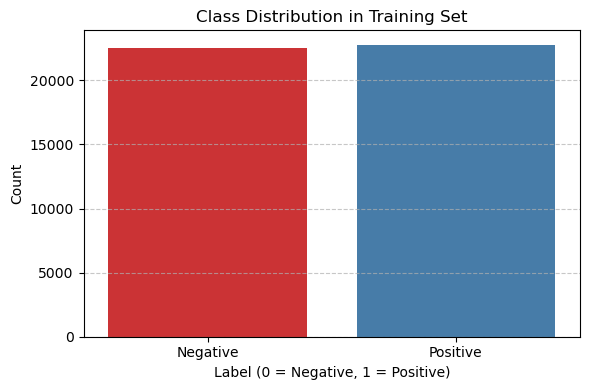

In [52]:
# Plot class distribution for training data
plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x='label', palette='Set1')
plt.title('Class Distribution in Training Set')
plt.xlabel('Label (0 = Negative, 1 = Positive)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


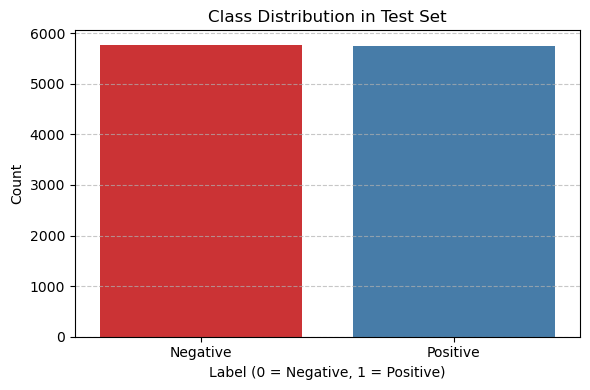

In [53]:
plt.figure(figsize=(6, 4))
sns.countplot(data=test_df, x='label', palette='Set1')
plt.title('Class Distribution in Test Set')
plt.xlabel('Label (0 = Negative, 1 = Positive)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [54]:
train_df.head()

,label,text
0,1,مقال يدور حول الحمي يوشك ان يقع فيه
1,1,تيشرت القائد
2,0,وكل السعوديه بدو حتي الحاضره منهم من اصل بدوي ...
3,0,المونافري طلع برهوش سدينا
4,0,منو خر بيتهم مثلنا


In [55]:
test_df.head()

,label,text
0,1,مسابقه والجائزه من اول من فتق لسانه بالعربيه ا...
1,0,ما لابن ادم والفخر اوله نطفه واخره جيفه ولا ير...
2,1,لاتحزن ودع القلقيستجيب لك الكريم هو ياخرها لوق...
3,0,بي الله يستر طلعتي من الدوام سيارتي وايد نازله...
4,0,تلاتين سنه بترقص الليله رقصتنا انا ببكي دي حلا...


In [6]:
train, valid = train_test_split(train_df, test_size=0.15, random_state=42, stratify=train_df['label'])

In [57]:
print(f"train size: {train.size}")
print(f"valid size: {valid.size}")
print(f"test size: {test_df.size}")

train size: 76966
valid size: 13584
test size: 23040


In [58]:
train.head()

,label,text
2720,0,اللهم ارحم عبدك احمد عشيه واجعل قبره مضيئا بنو...
32326,1,اليوم ذاكرتهم ولقيتهم بالتايم احبهم
8895,0,شير رتويت سبسكرايب ولا بحذف حسابك فورتنايت يانوب
3107,0,فراقك مو سهل عندي
20127,1,الحمد لله الف مبروك يازعماء القادم اجمل ان شاء...


## 4. Model Training and Evaluation

### 4.1 Helper Functions

In [7]:
def plot_confusion_matrix(y_true, y_pred):
    """Plot a confusion matrix for the given true and predicted labels."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

#### 4.1.1 Model Training Pipeline
The `train_model` function:
- Creates a pipeline with:
  1. CountVectorizer  --> Text to numerical features
  2. TfidfTransformer --> Apply TF-IDF weighting
  3. Specified classifier
- Trains and validates the model
- Returns the trained pipeline


In [8]:
def train_model(model, x_train, y_train, x_val, y_val):
    text_clf = Pipeline([
        ('vec', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', model)
    ])
    text_clf.fit(x_train, y_train)
    y_pred = text_clf.predict(x_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"Validation dataset accuracy with {model}: {acc}")
    return text_clf

#### 4.1.2 Model Evaluation
The `evaluate_model` function:
- Evaluates model on test data
- Calculates accuracy
- Generates confusion matrix visualization

In [11]:
def evaluate_model(model, X, Y):
    y_pred = model.predict(X)
    acc = accuracy_score(Y, y_pred)
    prec = precision_score(Y, y_pred)
    rec = recall_score(Y, y_pred)
    f1 = f1_score(Y, y_pred)
    print(f"Test dataset accuracy: {acc:.3f}")
    print(f"Test dataset precision: {prec:.3f}")
    print(f"Test dataset recall: {rec:.3f}")
    print(f"Test dataset f1-score: {f1:.3f}")
    plot_confusion_matrix(Y, y_pred)

### 4.2 Model Experiments

#### 4.2.1 Logistic Regression
- Simple linear model
- Good baseline for comparison

Validation dataset accuracy with LogisticRegression(random_state=42): 0.7545641931684335
Test dataset accuracy: 0.749
Test dataset precision: 0.759
Test dataset recall: 0.728
Test dataset f1-score: 0.743


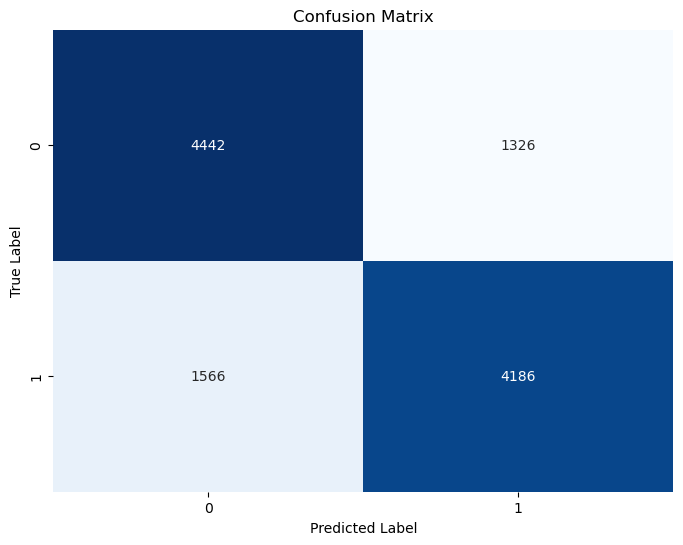

In [19]:
lg_clf = train_model(LogisticRegression(random_state=42), train['text'], train['label'], valid['text'], valid['label'])
evaluate_model(lg_clf, test_df['text'], test_df['label'])

#### 4.2.2 Decision Tree

Validation dataset accuracy with DecisionTreeClassifier(random_state=42): 0.7597173144876325
Test dataset accuracy: 0.760
Test dataset precision: 0.762
Test dataset recall: 0.754
Test dataset f1-score: 0.758


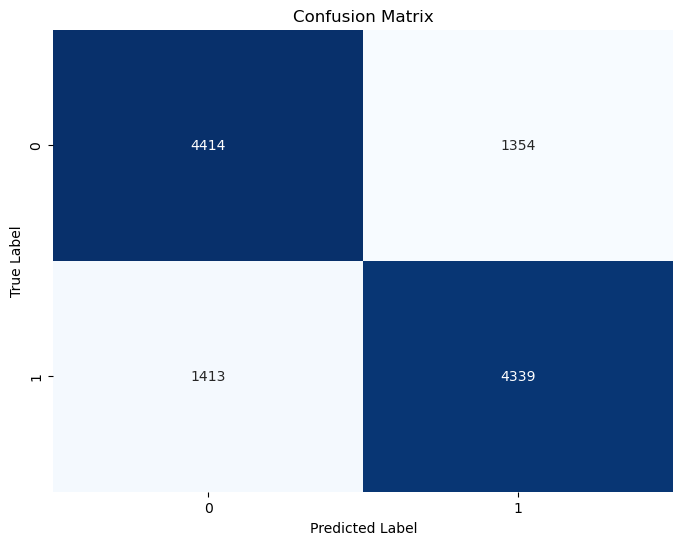

In [16]:
dt_clf = train_model(DecisionTreeClassifier(random_state=42), train['text'], train['label'], valid['text'], valid['label'])
evaluate_model(dt_clf, test_df['text'], test_df['label'])

#### 4.2.3 Support Vector Machine

Validation dataset accuracy with LinearSVC(random_state=42): 0.7636925795053003
Test dataset accuracy: 0.755
Test dataset precision: 0.759
Test dataset recall: 0.745
Test dataset f1-score: 0.752


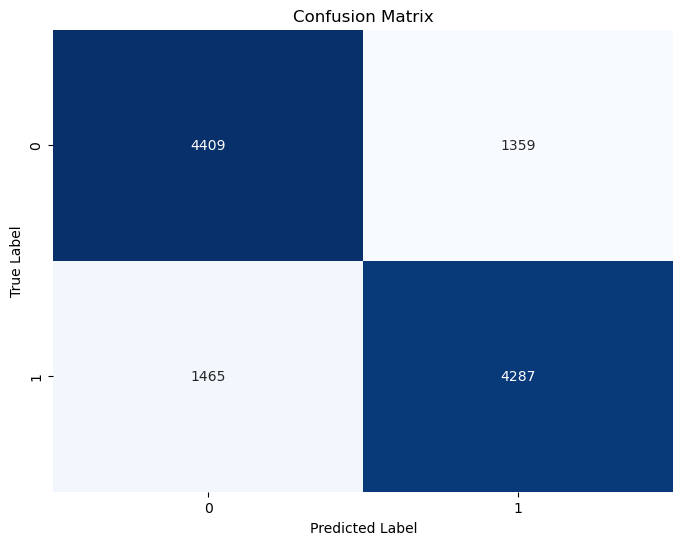

In [20]:
from sklearn.svm import LinearSVC

svc_clf = train_model(LinearSVC(random_state=42), train['text'], train['label'], valid['text'], valid['label'])
evaluate_model(svc_clf, test_df['text'], test_df['label'])

#### 4.2.4 Random Forest
- Ensemble of decision trees
- Best performing model

Validation dataset accuracy with RandomForestClassifier(random_state=42): 0.7863663133097762
Test dataset accuracy: 0.790
Test dataset precision: 0.820
Test dataset recall: 0.743
Test dataset f1-score: 0.780


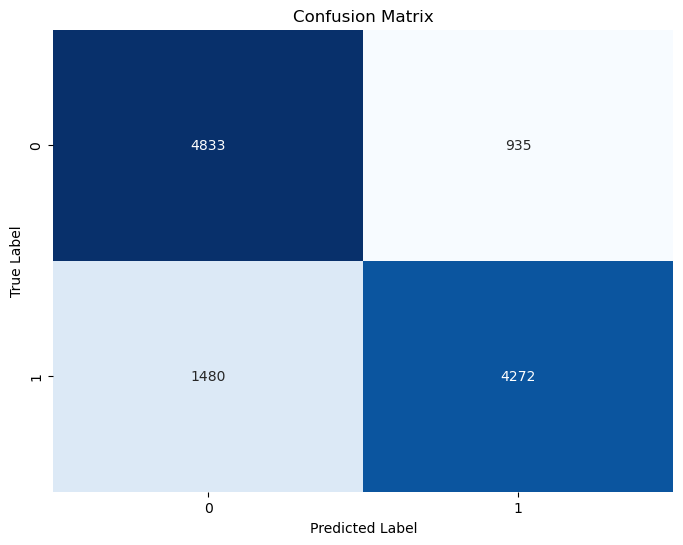

In [15]:
rnd_clf = train_model(RandomForestClassifier(n_estimators=100, random_state=42), train['text'], train['label'], valid['text'], valid['label'])
evaluate_model(rnd_clf, test_df['text'], test_df['label'])

### 4.3 Model Saving
- Saves the best performing model (Random Forest)
- Demonstrates real-time prediction

In [70]:
# save the model
from joblib import dump
dump(rnd_clf, 'rnd_clf.pkl')

# test the model
samples = ['صباح العسل', 'هذا الفيلم سيء', 'انا اشعر بالاحباط اليوم']
predictions = rnd_clf.predict(samples)
# Map the predictions to human-readable labels
label_map = {1: 'pos', 0: 'neg'}
mapped_predictions = [label_map[pred] for pred in predictions]

print(mapped_predictions)

['pos', 'neg', 'neg']
